In [1]:
# generate random Gaussian values
import random
from random import seed
from random import gauss
import math
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#metric
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


In [2]:
def fit_func(x, a, b, c):

  # Fit a curve as per this fitting function
  return a * np.log(x+ b) + c # c=0 is implied

In [3]:
def log_curve_fit(df,channel):

  #initialize x and y for each channel
  x = df[df["channel"] == channel]["spent"]
  y = df[df["channel"] == channel]["clicks"]

  # Curve fitting. We want the y intercept to be close zero, hence we bound the b and c variables of the equation
  popt, pcov = curve_fit(fit_func, x.to_numpy(), y.to_numpy(), bounds=(0, [50, 1., 0.0000001]))

  #Plot the results
  plt.plot(x, y, 'o', label='data')
  plt.plot(x, fit_func(x, *popt), 'o',
          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

  plt.title(str(channel) + ' Spend vs. CTR')
  plt.xlabel('Spent')
  plt.ylabel('Clicks')
  plt.legend()
  plt.show()

In [4]:
#learned best fit equations
#log functions for each channel

def channel_1_function(x, y_error_term = 0):
  return (4.977 * math.log(x+0.001)) + y_error_term

def channel_2_function(x, y_error_term = 0):
  return (9.987 * math.log(x+0.001)) + y_error_term

def channel_3_function(x, y_error_term = 0):
  return (15.968 * math.log(x+0.001)) + y_error_term

In [5]:
def get_function_value(row):
  #get the estimated clicks given expenditure using the learned best fit exponential model

  if row['channel'] == "Bing" :
    return channel_1_function(row["spent"])

  elif row['channel'] == "Facebook" :
    return channel_2_function(row["spent"])

  elif row['channel'] == "Google" :
    return channel_3_function(row["spent"])

In [6]:
#Calculate derivate functions for the cost curves for each channel for our optimization model 
#a small value is added to avoid ln(0)

#Bing
def slope_channel_1(x):
  return 4.988 / (x+0.0001)

#Facebook
def slope_channel_2(x):
  return 9.987 / (x+0.0001)

#Google
def slope_channel_3(x):
  return 15.968 / (x+0.0001)

In [7]:
def greedy_algo_optimal_values(budget):

  spend_dictionary = {1:0, 2:0, 3:0}
  spend = 0

  while spend < budget:
    #get slopes for
    slope_list = [slope_channel_1(spend_dictionary[1]), slope_channel_2(spend_dictionary[2]), slope_channel_3(spend_dictionary[3])]

    #get position that has max value. Add one to convert from position index to channel number
    max_slope_channel = slope_list.index(max(slope_list)) + 1 

    spend_dictionary[max_slope_channel] += 1
    spend += 1

  return spend_dictionary

## Load and Explore Dataset

In [8]:
df = pd.read_csv("synthetic_data.csv", index_col = 0)

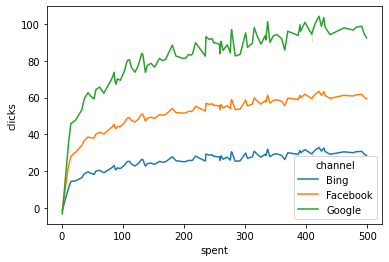

In [9]:
sns.lineplot(x = "spent", y = "clicks", data = df, hue = "channel")

Data appears to follow the diminishing returns pattern

## Fit Exponential Model to Dataset

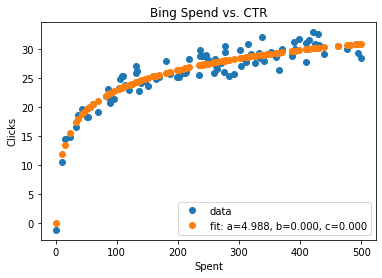

In [10]:
log_curve_fit(df,"Bing")

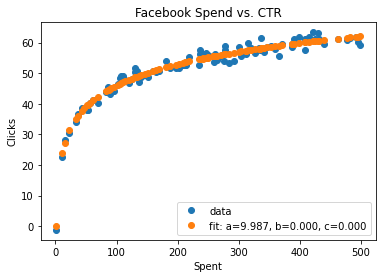

In [11]:
log_curve_fit(df,"Facebook")

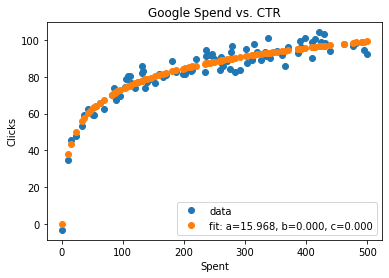

In [12]:
log_curve_fit(df,"Google")

In [13]:
#study the residuals
df["function_value"] = df.apply(lambda row: get_function_value(row), axis=1)
df["residuals"] = df["clicks"] - df["function_value"]

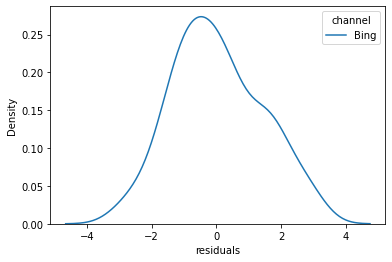

In [14]:
sns.kdeplot(data = df[df["channel"] == "Bing"], x = "residuals", hue = "channel")

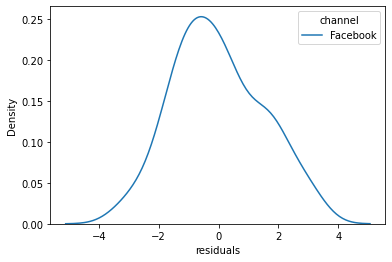

In [15]:
sns.kdeplot(data = df[df["channel"] == "Facebook"], x = "residuals", hue = "channel")

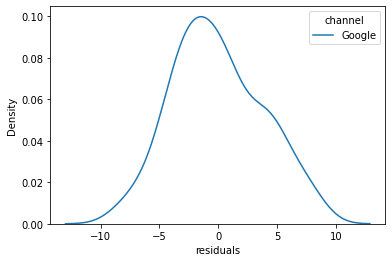

In [16]:
sns.kdeplot(data = df[df["channel"] == "Google"], x = "residuals", hue = "channel")

We observe that the residuals for each channel model appear to be fairly normally distributed

## Model Metric

In [17]:
df.head()

,spent,clicks,channel,function_value,residuals
0,69,19.211102,Bing,21.073220,-1.862118
1,33,16.572561,Bing,17.402269,-0.829707
2,131,25.874016,Bing,24.263895,1.610121
3,242,28.814998,Bing,27.318464,1.496534
4,334,28.456530,Bing,28.922064,-0.465533


In [18]:
def run_kfold(df_subset):
    
    X = df_subset["spent"]
    Y = df_subset["clicks"]
    pred_Y = df_subset["function_value"]
    
    kf = KFold(n_splits=5, shuffle = True, random_state = 44) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        predictions = pred_Y[test_index]
        accuracy = r2_score(Y_test, predictions)
        outcomes.append(accuracy)

    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    print("Mean f1: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 
    
    return Y_test, predictions

In [19]:
print("Bing Regression Model Fit Check")
df_temp = df[df["channel"] == "Bing"]
df_temp.reset_index(inplace = True, drop = True)
ytest_cv, ypred_cv = run_kfold (df_temp)

Bing Regression Model Fit Check
Mean f1: 0.9092763323368697
Standard Deviation: 0.03939734691242949


In [20]:
print("Facebook Regression Model Fit Check")
df_temp = df[df["channel"] == "Facebook"]
df_temp.reset_index(inplace = True, drop = True)
ytest_cv, ypred_cv = run_kfold(df_temp)

Facebook Regression Model Fit Check
Mean f1: 0.9718956001595958
Standard Deviation: 0.011578425682883914


In [21]:
print("Google Regression Model Fit Check")
df_temp = df[df["channel"] == "Google"]
df_temp.reset_index(inplace = True, drop = True)
ytest_cv, ypred_cv = run_kfold (df_temp)

Google Regression Model Fit Check
Mean f1: 0.9314820359283255
Standard Deviation: 0.02935700907624853


The best fit regression functions for each channel's cost curve are:

Bing
$f(x)=4.988*ln(x)$

Facebook
$f(x)=9.987*ln(x)$

Google
$f(x)=15.968*ln(x)$

The derivates for each channel's cost curve are:

Bing
$f(x)=\frac{4.988}{x}$

Facebook
$f(x)=\frac{9.987}{x}$

Google
$f(x)=\frac{15.968}{x}$



##Optimization

In [22]:
#calculate optimum spend for budget of $500
budget = 500
spend_dictionary = greedy_algo_optimal_values(budget)
print("Optimal spend for Bing is", spend_dictionary[1])
print("Optimal spend for Facebook is", spend_dictionary[2])
print("Optimal spend for Google is", spend_dictionary[3])


Optimal spend for Bing is 81
Optimal spend for Facebook is 161
Optimal spend for Google is 258


In [23]:
maximized_ctr = int(np.round(channel_1_function(spend_dictionary[1]) +  channel_2_function(spend_dictionary[2]) + channel_3_function(spend_dictionary[3]),0))
print("Expected clicks from optimized spending across channels is", maximized_ctr)

Expected clicks from optimized spending across channels is 161


In [24]:
google_all_in_ctr = int(channel_3_function(budget))
print("Expected clicks going all-in on Google is", google_all_in_ctr)

Expected clicks going all-in on Google is 99


If we were to put all of our money on Google, the expected number of clicks would only have been 100. By using a combination of the channels, we are using our marketing budget more efficiently to realize a lift of 62 on number of clicks.